In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

### Reading data

In [5]:
file_path="E:\ML\Frogs_MFCCs.csv"
data=pd.read_csv(file_path, header=None)
print(data.head())

         0                  1                    2                  3   \
0  MFCCs_ 1           MFCCs_ 2             MFCCs_ 3           MFCCs_ 4   
1         1  0.152936298220384   -0.105585902844019  0.200721914808566   
2         1  0.171534257314109  -0.0989747371205295  0.268425220827017   
3         1  0.152317085189856  -0.0829726738725973  0.287127957306532   
4         1   0.22439244572155    0.118984663992927  0.329431728991851   

                  4                  5                    6   \
0           MFCCs_ 5           MFCCs_ 6             MFCCs_ 7   
1  0.317201062343259  0.260763853131077    0.100944640810053   
2  0.338671862995453  0.268353099863332   0.0608350871920449   
3  0.276014083988895  0.189866772581424  0.00871395674901959   
4   0.37208800967925   0.36100456768708   0.0155010402636969   

                   7                    8                  9   ...  \
0            MFCCs_ 8             MFCCs_ 9           MFCCs_10  ...   
1  -0.150062604917616    -0.17

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\HP\AppData\Local\Temp\ipykernel_19648\3029477449.py:1: SyntaxWarning: invalid escape sequence '\M'
  file_path="E:\ML\Frogs_MFCCs.csv"


### Step 1: Data Preprocessing and Exploration

In [6]:
# Selecting only the first 10 columns assuming these are MFCC features
mfcc_data = data.iloc[:, :10].apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values
mfcc_data = mfcc_data.dropna()
    
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(mfcc_data)

# Feature Engineering
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(scaled_data)

### Feature Correlation Analysis

In [7]:
# Feature Correlation Analysis
corelated_matrix = pd.DataFrame(scaled_data).corr().abs()
upper_tri = corelated_matrix.where(np.triu(np.ones(corelated_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
reduced_data = pd.DataFrame(scaled_data).drop(columns=to_drop, axis=1)

### Step 2: K-Means Clustering

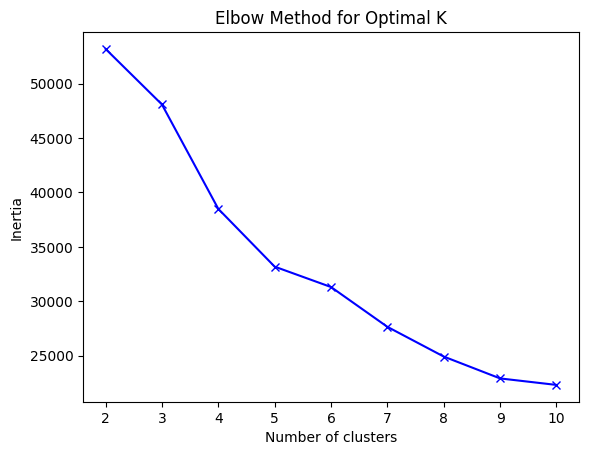

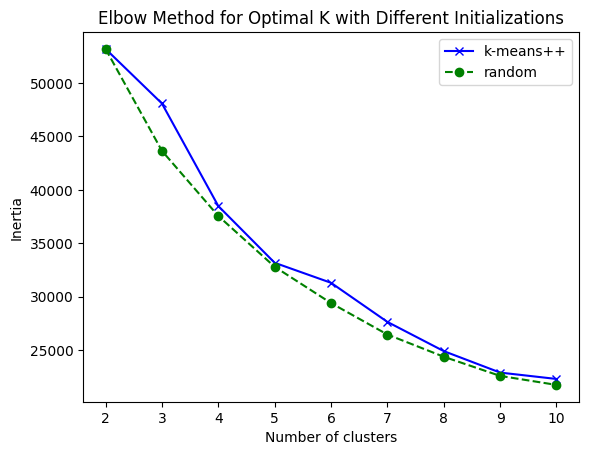

Silhouette Score for k=6: 0.2171895893163682


In [8]:
# Performing K-Means Clustering
# Elbow Method to find the optimal number of clusters
inertia = []
K = range(2, 11)

# Elbow method with KMeans++ initialization
for k in K:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=39)
    kmeans.fit(reduced_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(K, inertia, 'bx-', label="k-means++")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Comparison with rnadom initialization
inertia_random = []
for k in K:
    kmeans_random = KMeans(n_clusters=k, init="random", random_state=39)
    kmeans_random.fit(reduced_data)
    inertia_random.append(kmeans_random.inertia_)

# Plot comparison of initializations
plt.plot(K, inertia, 'bx-', label="k-means++")
plt.plot(K, inertia_random, 'go--', label="random")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K with Different Initializations')
plt.legend()
plt.show()

# Choose optimal K and fit KMeans
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, init="k-means++", random_state=39)
clusters = kmeans.fit_predict(reduced_data)

# Silhouette Score Evaluation
sil_score = silhouette_score(reduced_data, clusters)
print(f'Silhouette Score for k={optimal_k}: {sil_score}')

### Step 3: Cluster Visulaization

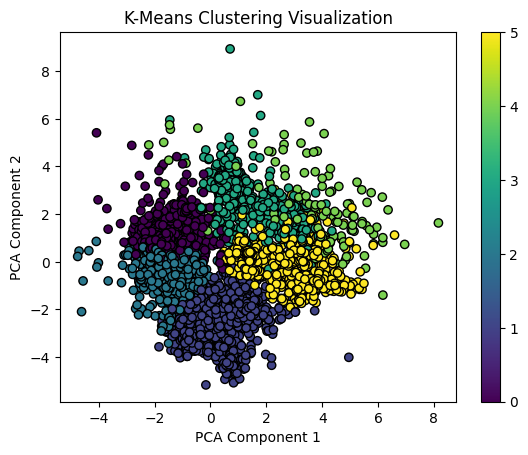

Explained Variance Ratio by PCA Components: [0.32982848 0.24783481]


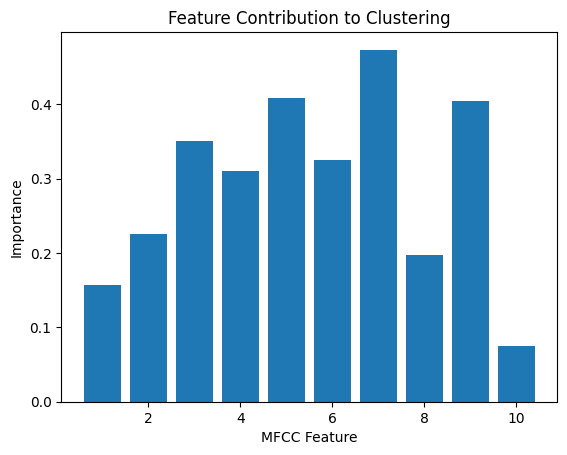

In [9]:
# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(reduced_data)

# Scatter plot of clusters
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering Visualization')
plt.colorbar()
plt.show()

# Feature Contribution to Clustering Analysis
print("Explained Variance Ratio by PCA Components:", pca.explained_variance_ratio_)
feature_importances = np.abs(pca.components_[0])
feature_importances_df = pd.DataFrame({'Feature': range(1, len(feature_importances) + 1), 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.bar(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('MFCC Feature')
plt.ylabel('Importance')
plt.title('Feature Contribution to Clustering')
plt.show()

### Step 4: Cluster Evaluation Metrics

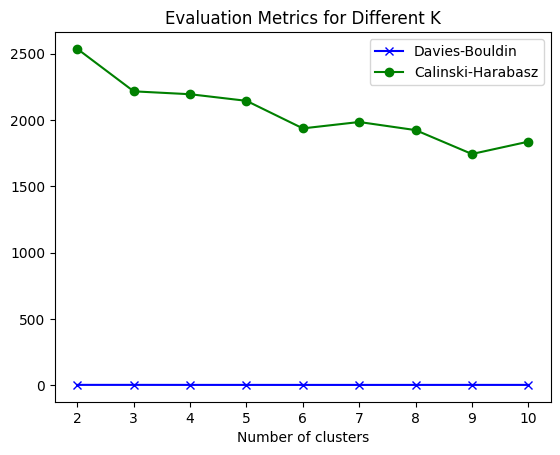

Davies-Bouldin Index for k=6: 1.2492901113817467
Calinski-Harabasz Score for k=6: 1836.7370919310051


In [10]:
# Cluster Evaluation Metrics across different K values
db_scores = []
ch_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    clusters = kmeans.fit_predict(reduced_data)
    db_scores.append(davies_bouldin_score(reduced_data, clusters))
    ch_scores.append(calinski_harabasz_score(reduced_data, clusters))

# Plot evaluation metrics
plt.plot(K, db_scores, 'bx-', label='Davies-Bouldin')
plt.plot(K, ch_scores, 'go-', label='Calinski-Harabasz')
plt.xlabel('Number of clusters')
plt.title('Evaluation Metrics for Different K')
plt.legend()
plt.show()

# Evaluation for chosen K
db_index = davies_bouldin_score(reduced_data, clusters)
ch_score = calinski_harabasz_score(reduced_data, clusters)
print(f'Davies-Bouldin Index for k={optimal_k}: {db_index}')
print(f'Calinski-Harabasz Score for k={optimal_k}: {ch_score}')

### Step 5: Comparison with Agglomerative Clustering

In [11]:
# Comparison with Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k)
agg_clusters = agg_clustering.fit_predict(reduced_data)

# Evaluation Metrics for Agglomerative Clustering
sil_score_agg = silhouette_score(reduced_data, agg_clusters)
db_index_agg = davies_bouldin_score(reduced_data, agg_clusters)
ch_score_agg = calinski_harabasz_score(reduced_data, agg_clusters)
print(f'Agglomerative Clustering - Silhouette Score: {sil_score_agg}')
print(f'Agglomerative Clustering - Davies-Bouldin Index: {db_index_agg}')
print(f'Agglomerative Clustering - Calinski-Harabasz Score: {ch_score_agg}')

Agglomerative Clustering - Silhouette Score: 0.3659198595506239
Agglomerative Clustering - Davies-Bouldin Index: 1.2071744221391711
Agglomerative Clustering - Calinski-Harabasz Score: 1801.565301709295
